# 4th lab:

### Area info:

In [70]:
bottom_left = (29.073321247506765, 49.845775018245774)
upper_right = (31.986007792928522, 51.278667808079206)

#Filtering options:
from_time = "2019-04-01T00:00:00Z"
to_time = "2020-05-01T00:00:00Z"
maxCloudCoverage = 0

#In px:
width = 2000
height = 2000

## First part:

### Create session with server:

In [71]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

def get_token():
    client_id = "8d7432b3-19c9-4a6e-9d02-fcf865d1a6c6"
    client_secret = "fdR{0FFu(}F)KD/s@>9(w;28*]MHkQJoo_I!*Q73"


    client = BackendApplicationClient(client_id=client_id)
    oauth = OAuth2Session(client=client)


    token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                              client_id=client_id, client_secret=client_secret)
    return token['access_token']

token = get_token()

### get_image(satellite: str, bands, merge=True, img_name: str = "image", img_format: str = "tiff"):
___

*satellite*: str. Satellite name (sentinel/landsat).

*bands*: list or int. Bands to download.

*merge*=__True__: bool. If __True__, merges all bands in one images. If __False__, downloads bands separately and saves them in it's individual file.

*img_name*="image": str. Name of image.

*img_format*="tiff": str. Image format.
___

In [72]:
import requests
import os

def get_image(satellite: str, bands, merge=True, img_name: str = "image", img_format: str = "tiff"):
    if not os.path.isdir("data"):
        os.mkdir("data")  
    if not os.path.isdir(f"data/{satellite}"):
        os.mkdir(f"data/{satellite}")
        
    if type(bands) is not type(list()):
        bands = [bands]
    
    
    band_names = {
        4: "r", 
        3: "g", 
        2: "b", 
        8: "b08",
    }
    band_id = {
        4:"B04",
        3:"B03",
        2:"B02",
        8:"B08",
    }
    satellite_id = {
        "sentinel": "S2L2A",
        "landsat": "L8L1C",
    }
    urls = {
        "sentinel": "https://services.sentinel-hub.com/api/v1/process",
        "landsat": "https://services-uswest2.sentinel-hub.com/api/v1/process",
    }
    
    
    if not merge:
        for band in bands:
            get_image(satellite, band, img_format=img_format, merge=True, img_name=band_names[band])
        return

    
    evaluate_pixel_output = "["
    for i in list(band_id.keys()):
        if i in bands:
            evaluate_pixel_output += "2.5 * sample." + band_id[i] + ", "
    evaluate_pixel_output = evaluate_pixel_output[:-2] + "]"
    
    
    evalscript = """
        //VERSION=3

        function setup() {
          return {
            input: """ + str([band_id[i] for i in bands]) + """, 
            output: {
              bands: """ + str(len(bands)) + """
            }
          };
        }

        function evaluatePixel(
          sample,
          scenes,
          inputMetadata,
          customData,
          outputMetadata
        ) {
          return """ + evaluate_pixel_output + """; 
        }
        """
    
    # Checking token:
    try:
        resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
    except Exception as e:
        #if e.error == "token_expired":
        token = get_token()    
        
    req_data = {
        "input": {
            "bounds": {
                "bbox": [
                    bottom_left[0],
                    bottom_left[1],
                    upper_right[0],
                    upper_right[1],
                ]
            },
            "data": [
                {
                    "type": satellite_id[satellite],
                    "dataFilter": {
                        "timeRange": {
                            "from": from_time,
                            "to": to_time,
                        },
                        "maxCloudCoverage": maxCloudCoverage,
                    },
                }
            ]
        },
        "output": {
            "width": width,
            "height": height,
            "responses": [{
                "format": {
                    "type": "image/" + img_format
                }
            }]
        },
        "evalscript": evalscript
    }
    headers = {
        "Authorization": f"Bearer {token}",
    }
    url = urls[satellite]
            

    response = requests.post(url, json=req_data, headers=headers)

    with open(f"data/{satellite}/{img_name}.{img_format}", "wb") as img:
        img.write(response.content)

### Getting all necessary bands:

In [73]:
get_image("sentinel", bands=[2, 3, 4, 8], merge=False)

In [74]:
def clear_dir(directory):
    for file in glob.glob(os.path.join(directory, "*.tif")):
        os.remove(file) #delete all previous data
clear_dir('D:/python_data_science/lab_4_united/Data-Science/4/data/')

In [75]:
import glob
import gdal 
import os
#clean the directory

band_names = {
        2: "b", 
        3: "g",
        4: "r",
        8: "b08"} #sentinel if || lansat panchromatic light  
#D:\python_data_science\lab_4_united\Data-Science\4\data\sentinel
for value in band_names.values():
    path = os.path.normpath(f"data/sentinel/{str(value)}.tiff")
    print(path)
    gdalData = gdal.Open(path) 
    exec('gdalData_%s = gdalData' % value)
    
    # проверяем все ли в порядке
    if gdalData is None:
        print ("ERROR: can't open raster")
        break


data\sentinel\b.tiff
data\sentinel\g.tiff
data\sentinel\r.tiff
data\sentinel\b08.tiff


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess, glob
#from osgeo import gdal

In [77]:
files_to_mosaic = glob.glob("data/sentinel/*.tiff")
files_to_mosaic

['data/sentinel\\b.tiff',
 'data/sentinel\\b08.tiff',
 'data/sentinel\\g.tiff',
 'data/sentinel\\r.tiff']

In [78]:
files_string = " ".join(files_to_mosaic)
print(files_string)

data/sentinel\b.tiff data/sentinel\b08.tiff data/sentinel\g.tiff data/sentinel\r.tiff


In [79]:
command = "python gdal_merge.py -o merged.tif -of gtiff " + files_string
output = subprocess.check_output(command)
output

b'0...10...20...30...40...50...60...70...80...90...100 - done.\n'

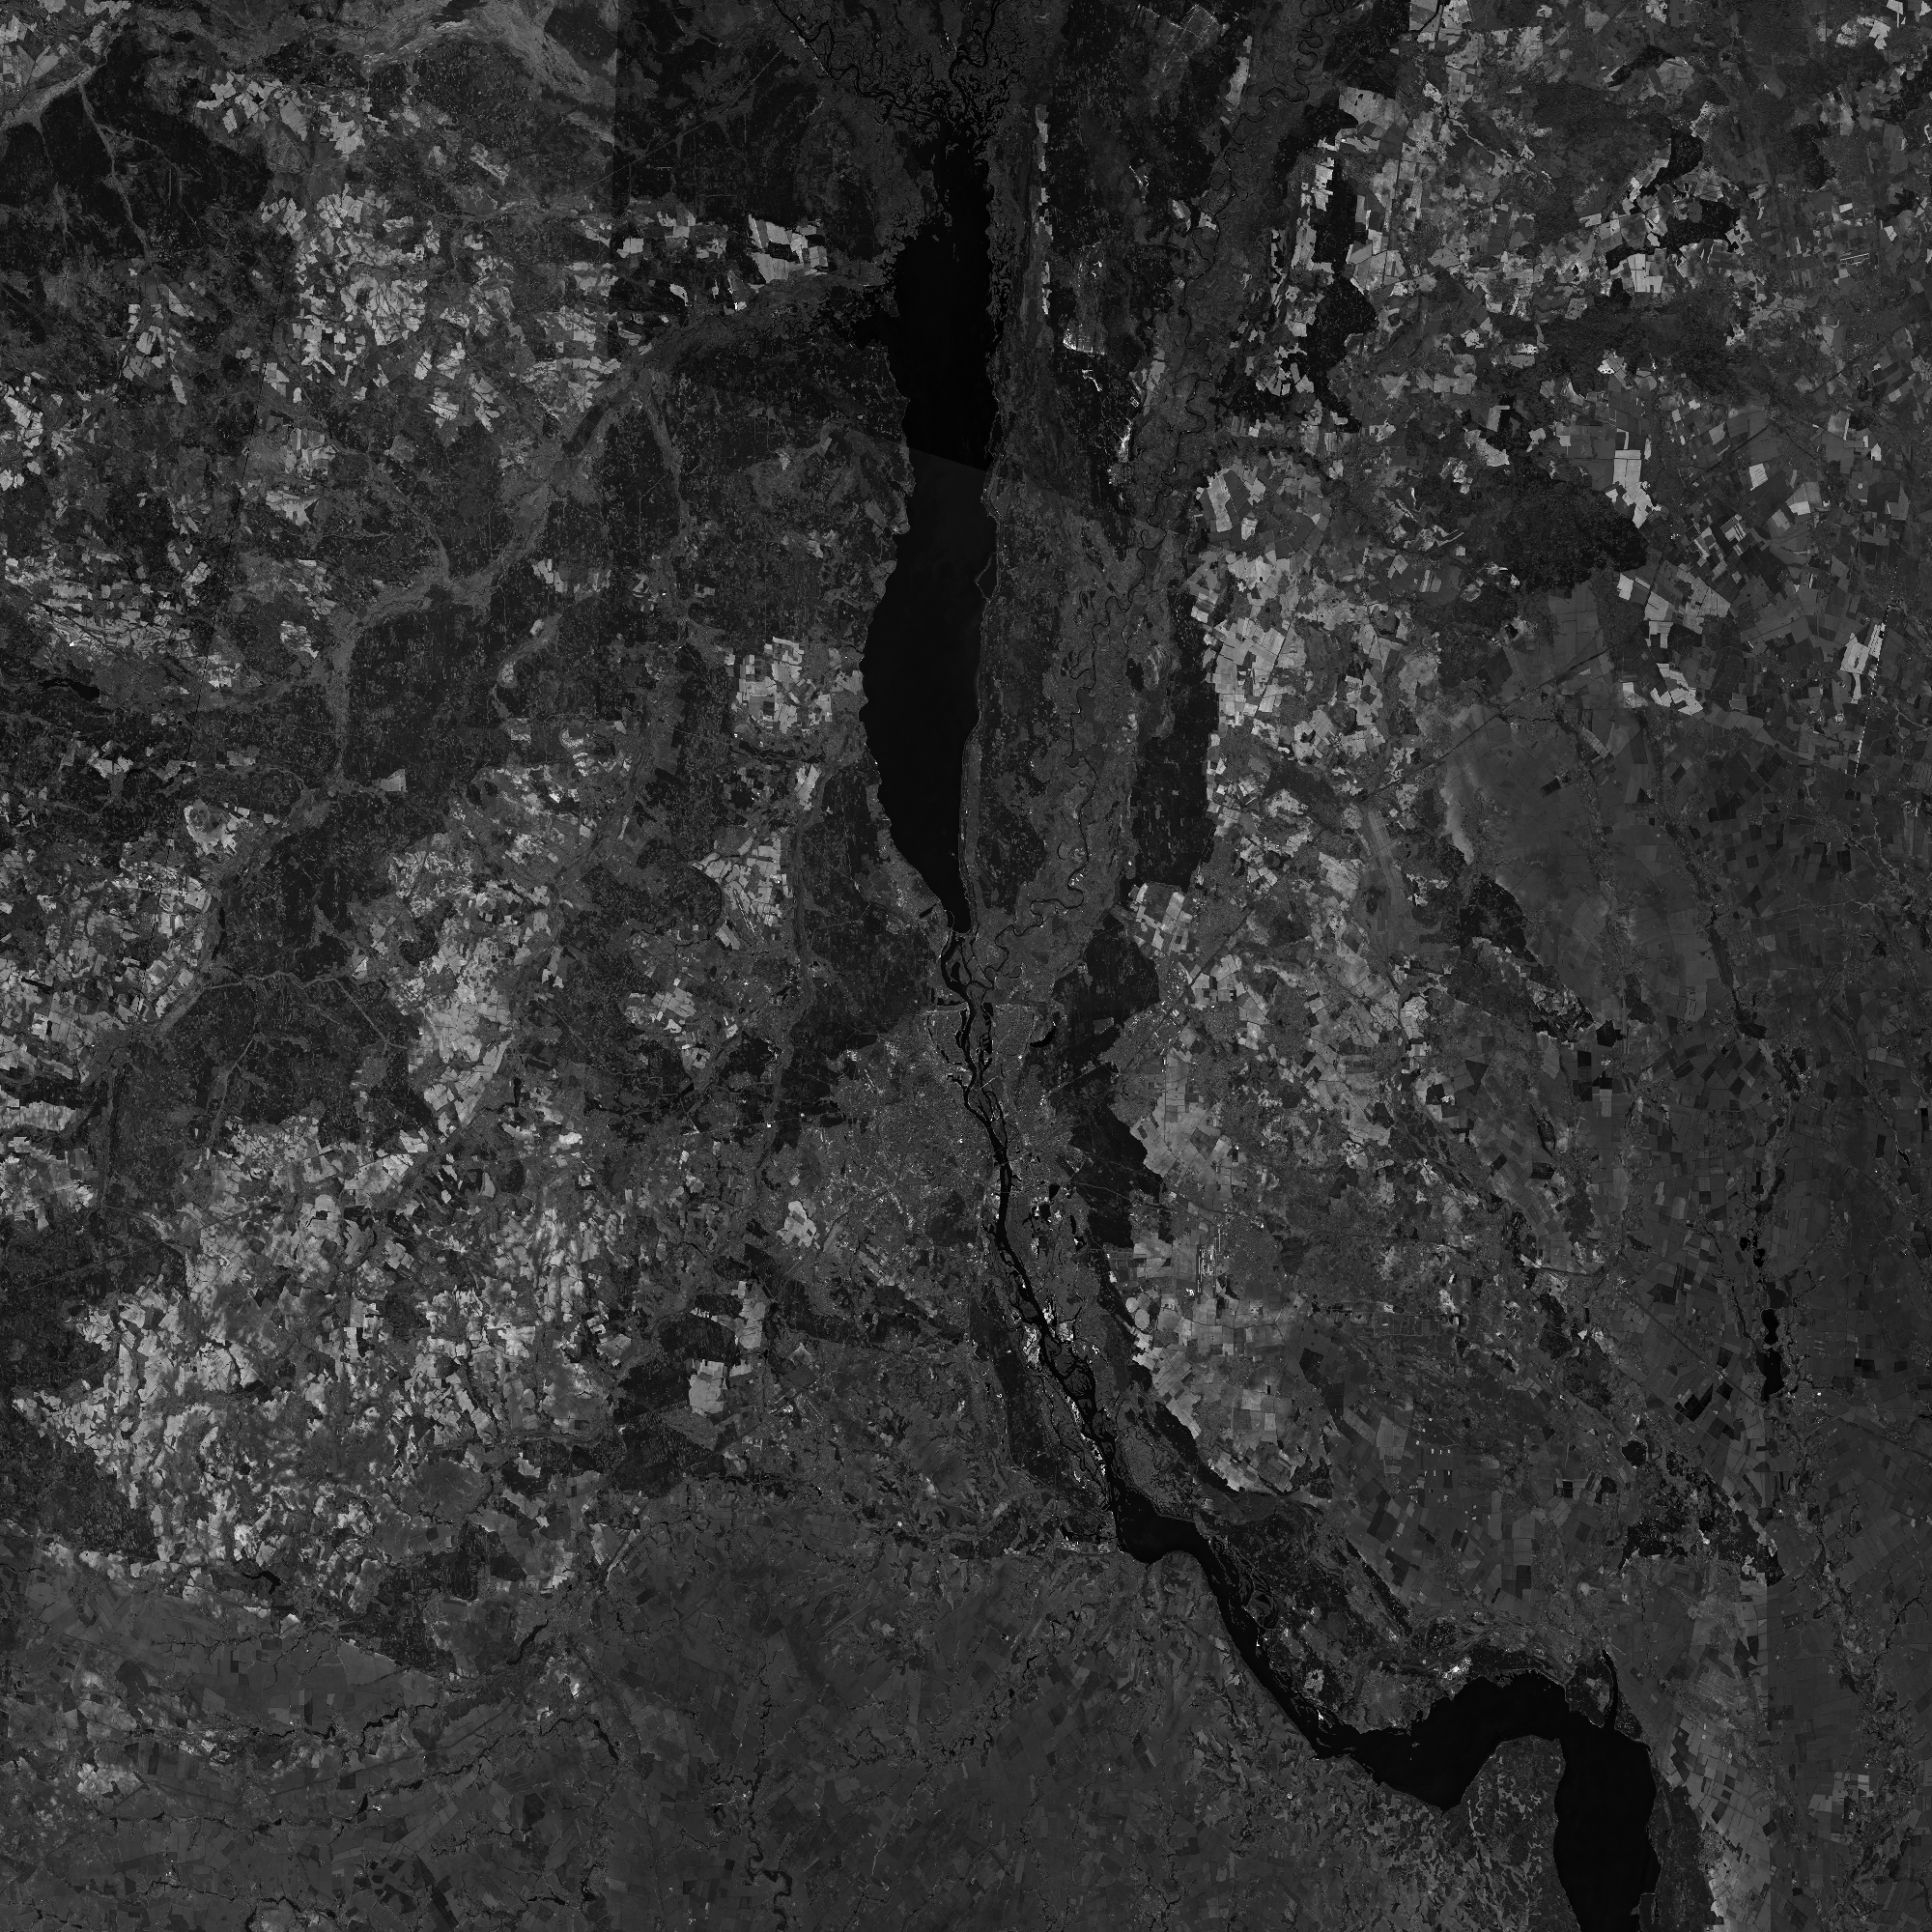

In [80]:
from PIL import Image
im = Image.open("merged.tif")
#im.save('test.jpeg')
im

Перепроектування зображення. Для зміни географічної проекції зображення потрібно скористатися командою gdalwarp, наприклад: 
 
gdalwarp –tr xSize ySize –t_srs “[projection parameters]” <input.tif> <output.tif> 
 
де xSize,ySize – розміри пікселя результуючого зображення; [projection parameters] – параметри проекції, в яку буде здійснюватися перепроектування, наприклад “+proj=utm +zone=36” – параметри проекції UTM Zone 36N. Для подальшого обрізання зображення по векторному контуру, потрібно буде звести растр з векторним контуром до єдиної проекції. Детальніше — https://gdal.org/programs/gdalwarp.html 

In [81]:
#command = :'gdalwarp –tr xSize ySize –t_srs "[projection parameters]" merged.tif projection.tif'